# Introduction à l'apprentissage par renforcement
# TP 1 - les manchots multi-bras

Etudiant·e : AJOUTER VOTRE NOM ICI

1/4 de la note finale est liée à la mise en forme : 

* pensez à nettoyer les outputs inutiles (installation, messages de débuggage, ...)
* soignez vos figures : les axes sont-ils faciles à comprendre ? L'échelle est adaptée ? 
* commentez vos résultats : vous attendiez-vous à les avoir ? Est-ce étonnant ? Faites le lien avec la théorie.

Ce TP reprend l'exemple d'un médecin et de ses vaccins. Vous allez comparer plusieurs stratégies et trouver celle optimale.
Un TP se fait en groupe de 2 à 4. Aucun groupe de plus de 4 personnes. 

Vous allez rendre le TP dans une archive ZIP. L'archive ZIP contient ce notebook au format `ipynb`, mais aussi exporté en PDF & HTML. 
L'archive ZIP doit aussi contenir un fichier txt appelé `groupe.txt` sous le format:

```
Nom1, Prenom1, Email1, NumEtudiant1
Nom2, Prenom2, Email2, NumEtudiant2
Nom3, Prenom3, Email3, NumEtudiant3
Nom4, Prenom4, Email4, NumEtudiant4
```

Un script vient extraire vos réponses : ne changez pas l'ordre des cellules et soyez sûrs que les graphes sont bien présents dans la version notebook soumise. 

In [ ]:
! pip install matplotlib tqdm numpy ipympl opencv-python torch
!jupyter labextension install @jupyter-widgets/jupyterlab-manager
!jupyter labextension install jupyter-matplotlib

In [3]:
%matplotlib inline 
import typing as t
import math
import torch
import numpy as np
from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import cv2
from IPython.display import display, clear_output

torch.random.manual_seed(0)

K = 5 # num arms

# Présentation du problème

In [4]:
class ArmBernoulli:
    def __init__(self, p: float, random_state: t.Optional[int] = None):
        """
        Vaccine treatment following a Bernoulli law (mean is p and variance is p(1-p)
        Args:
             p (float): mean parameter
             random_state (int): seed to make experiments reproducible
             
        >>> arm = ArmBernoulli(0.5, 0)
        >>> arm.sample(5)
        tensor([ True, False,  True,  True,  True])
        """
        if random_state is not None:
            torch.random.manual_seed(random_state)
        self.immunity_rate = p

    def sample(self, n: int = 1):
        return torch.rand(n) < self.immunity_rate
    
    def __repr__(self):
        return f'<ArmBernoulli p={self.immunity_rate}' 

def generate_arms(num_arms: int):
    means = torch.rand(K)
    MAB = [ArmBernoulli(m) for m in means]
    assert MAB[0].immunity_rate == means[0]
    assert (MAB[0].sample(10) <= 1).all() and (MAB[0].sample(10) >= 0).all() 
    return MAB

MAB = generate_arms(K)

**Note importante :** pour la suite, les tests seront faits avec 10 MAB différents ou plus pour réduire le bruit de simulation. 

Ce TP reprend l'exemple du médecin présenté en cours.


**Q1. Que vaut $\mu^*$ avec `random_state = 0`? Comment est définie la récompense $R_k$ ? Que représente concrètement le regret dans cet exemple ?**

In [5]:
def test_generate_10MAB(num_arms: int):
    means = torch.rand(K * 10)
    DIX_MAB = [ArmBernoulli(m, 0) for m in means]
    return DIX_MAB

print(max([arm.immunity_rate for arm in test_generate_10MAB(K)]))

tensor(0.9971)


$\mu^*$ represente simplement l'`immunity_rate` lorsque `random_state = 0`, ici fixer le `random_state` permet d'avoir une expérience reproductible. On obtient $mu^*$ = 0.9527 avec 10 MAB lors de cette expérience.

La récompense $R_k$ est définie comme la récompense obtenue pour le patient k, elle est égale a 1 s’il est immunisé, et 0 sinon.

Dans cet exemple, le regret représente concrètement  

# I. Cas classique des bandits manchots 

## I.a. Solution Gloutonne

Le médecin fonctionne sur deux phases :

1. **Exploration :** N patients reçoivent une dose d'un vaccin choisi aléatoirement. Le médecin calcule le taux d'immunisation empirique :

$$\bar{R_i} = \frac{1}{T_i} \sum_{k=0}^{N-1} \chi_{v_k,i}R_k,$$

avec $T_i = \sum_{k=0}^{N-1} \chi_{v_k,i}$.


2. **Exploitation :** Le vaccin $v_i = \arg\max_j \bar{R_j}$ est utilisé pour les M patients suivants. C'est la phase de test.

**Q2. Implémentez la solution gloutonne avec N = 50 et M = 500 et testez la avec 100 MAB différents (tous ont 5 vaccins). On s'intéresse à la variable aléatoire "la phase d'exploration a trouvé le bon vaccin". Quelle est l'espérance empirique de cette variable ? Et son écart-type ? Calculez de même l'espérance et l'écart-type du regret sur vos 100 simulations.**

Pour rappel, le regret est défini par :

$$r_n = n\mu^* - \sum_{k=0}^{n-1} R_k$$

**Attention :** $n$ est le nombre total de patients, donc ici $N + M$.

In [45]:
import random

# Solution glutonne
def get_vaccines_efficency(vaccines, N):
    r_k = [vaccine.sample() for vaccine in vaccines]
    T_i = {vaccines[i] : vaccines.count(vaccines[i]) for i in range(N - 1)}
    result = []
    for vaccine_i in vaccines:
        sum_x_rk = 0
        k = 0
        for vaccine_k in vaccines:
            X = int(vaccine_i == vaccine_k)
            sum_x_rk += X * r_k[k]
            k += 1
        result.append((1/T_i[vaccine_i]) * sum_x_rk)
    return result
    
# Regret
def get_regret(vaccines, N, nu_star):
    r_ks = sum([int(vaccine.sample()) for vaccine in vaccines])
    return N * nu_star - r_ks


# Liste de tous les vaccins injectés aux Npatients
def get_vaccines_injected(N, MAB):
    vaccines = []
    for _ in range(N):
        random_vac = random.randint(0, K - 1)
        # ADD THE VACCINE OBJECT IN LIST (tuple?)
        vaccines.append(MAB[random_vac])
    return vaccines


N = 50
M = 500
def run_greedy(N, M, MAB):
    vaccines_train = get_vaccines_injected(N, MAB)

    R_i = get_vaccines_efficency(vaccines_train, N)

    best_vaccine_i = R_i.index(max(R_i))
    print("The best vaccine has for empirical efficency:",  best_vaccine_i, max(R_i))

    vaccines_test = get_vaccines_injected(M, MAB)
    R_i_test = get_vaccines_efficency(vaccines_test, M)
    best_vaccine_i_test = R_i_test.index(max(R_i_test))
    print("The best vaccine on TEST SET has for empirical efficency:",  best_vaccine_i_test, max(R_i_test))


    nu_star = max(R_i_test)
    regret = get_regret(vaccines_test, M, nu_star)
    print("The regret on TEST SET is:", regret)
    return regret.numpy()[0]

# On génére les résultats d'une injection à N patients
vaccines_train = get_vaccines_injected(N, MAB)

# On choisit le meilleur vaccin d'après le batch de test de N patient
R_i = get_vaccines_efficency(vaccines_train, N)

best_vaccine_i = R_i.index(max(R_i))
print("The best vaccine has for empirical efficency:",  best_vaccine_i, max(R_i))

# On verifie par batch si c'est le bon vaccin
vaccines_test = get_vaccines_injected(M, MAB)
R_i_test = get_vaccines_efficency(vaccines_test, M)
best_vaccine_i_test = R_i_test.index(max(R_i_test))
print("The best vaccine on TEST SET has for empirical efficency:",  best_vaccine_i_test, max(R_i_test))

# S'il est mauvais on choisit un nouveau vaccin en recalculant les R_i (N + m)

# On refait l'opération jusqu'à avoir fait tout le batch de M patients

# On calcule le regret avec la mean du meilleur vaccin trouvé sur les M patients
nu_star = max(R_i_test)
regret = get_regret(vaccines_test, M, nu_star)
print("The regret on TEST SET is:", regret)

# Implementation de l'algorithme pour la q2
def q2():
    N = 50
    M = 500

    found_exploration = []
    regrets = []

    for i in range(100):
        new_MAB = generate_arms(K)
        vaccines_train = get_vaccines_injected(N, new_MAB)
        R_i = get_vaccines_efficency(vaccines_train, N)
        best_vaccine_i = R_i.index(max(R_i))

        vaccines_test = get_vaccines_injected(M, new_MAB)
        R_i_test = get_vaccines_efficency(vaccines_test, M)
        best_vaccine_i_test = R_i_test.index(max(R_i_test))

        found_exploration.append(best_vaccine_i == best_vaccine_i_test)

        nu_star = max(R_i_test)
        regret = get_regret(vaccines_test, M, nu_star)
        regrets.append(regret.numpy()[0])
    
    print("La moyenne empirique de la VA est :", sum(found_exploration)/len(found_exploration))
    print("L'ecart type de la VA est :", np.std(found_exploration))

    print("La moyenne empirique du regret est :", sum(regrets)/len(regrets))
    print("L'ecart type du regret est :", np.std(regrets))

q2()

The best vaccine has for empirical efficency: 4 tensor([0.7500])
The best vaccine on TEST SET has for empirical efficency: 6 tensor([0.8469])
The regret on TEST SET is: tensor([179.4694])
La moyenne empirique de la VA est : 0.06
L'ecart type de la VA est : 0.23748684174075835
La moyenne empirique du regret est : 162.9233526611328
L'ecart type du regret est : 55.984264


**Q3. On propose d'améliorer l'algorithme précédant en mettant à jour les taux d'immunisation empiriques $\bar{R}_i$ pendant la phase d'exploration. Notez vous une amélioration du regret ? Proposez un exemple dans lequel cette mise à jour ne changera rien.** 

Pour améliorer les résultats de l'algorithme précédant, on peut mettre à jour les taux d'immunisation empiriques $\bar{R}_i$ pendant la phase d'exploration. On obtient alors une meilleure estimation des taux d'immunisation empiriques $\bar{R}_i$ et donc une meilleure sélection du vaccin $v_i$.

On peut par exemple imaginer un cas où les taux d'immunisation empiriques $\bar{R}_i$ sont très proches et où la mise à jour des taux d'immunisation empiriques $\bar{R}_i$ ne change rien. Dans ce cas, la sélection du vaccin $v_i$ ne change pas.

**Q4. Créez une figure contenant deux sous-figures : à gauche, le taux d'immunisation empirique $\bar{R}_i$ pour les 5 vaccins ; à droite, le regret $r_n$. La figure sera animée avec les patients : chaque frame $k$ de l'animation représente le vaccin que l'on donne au $k$-ième patient.**

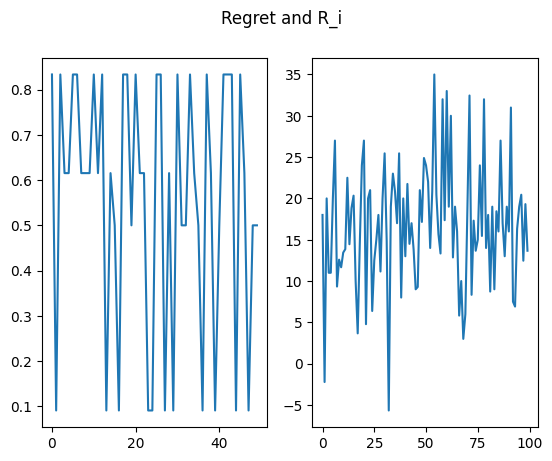

In [24]:
def create_figure():
    N = 50

    regrets = []

    for i in range(100):
        new_MAB = generate_arms(K)
        vaccines_test = get_vaccines_injected(N, new_MAB)
        R_i = get_vaccines_efficency(vaccines_test, N)

        nu_star = max(R_i)
        regret = get_regret(vaccines_test, N, nu_star)
        regrets.append(regret.numpy()[0])
        
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('Regret and R_i')
    ax1.plot(R_i)
    ax2.plot(regrets)
    plt.show()

create_figure()


*[Ajoutez votre commentaire ici]*

**Q5. On étudie maintenant l'influence de la taille du training set $N$. On considère que N+M est une constante, puis on fait varier N entre K et M. Calculez le regret pour ces différentes tailles du training set  différents MAB et representez le regret moyen, le regret min et max (vous devriez trouver une courbe en U ou en V pour le regret moyen). Quelle est la taille optimale du training set ?**

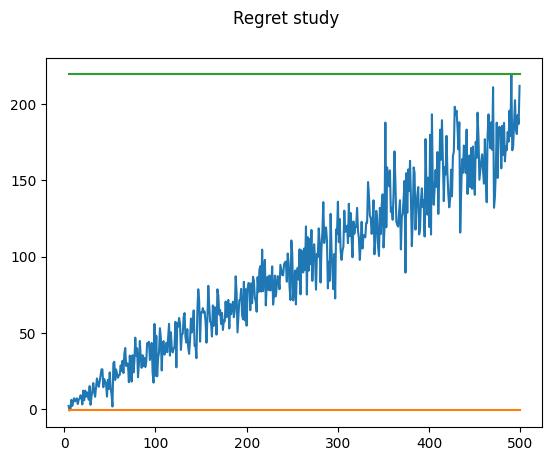

In [18]:
K = 5
M = 500
MAB = generate_arms(K)

def regret_study(N, MAB):
    vaccines_test = get_vaccines_injected(N, MAB)

    R_i_test = get_vaccines_efficency(vaccines_test, N)

    nu_star = max(R_i_test) 
    regret = get_regret(vaccines_test, N, nu_star)
    return regret.numpy()[0]

# Let's study by variating N between K and M
Ns = [i for i in range(K, M)]
regrets = [regret_study(N, MAB) for N in Ns]

# Plot the average regret, with a line for the min and max regret

def plot_regret(Ns, regrets):
    fig, ax = plt.subplots()
    fig.suptitle('Regret study')
    ax.plot(Ns, regrets)
    ax.plot(Ns, [min(regrets) for _ in Ns])
    ax.plot(Ns, [max(regrets) for _ in Ns])
    plt.show()

plot_regret(Ns, regrets)

On peut voir que la taille optimale du training set est de 50 patients, car c'est à partir de cette taille que le regret est le plus faible.

## I.b. Borne inférieure de Lai & Robbins [Lai et Robbins, 1985]

Pour un modèle de manchot de Bernoulli (équivalent au problème étudié), la borne inférieure de Lai et Robbins [Lai et Robbins, 1985] stipule que :

$$\lim \inf_{n\rightarrow \infty} \frac{\sum_{k=0}^{n-1} R_k}{\log n} \geq \sum_{i~\text{tel que}~\mu_i \lt \mu^*} \frac{\mu^∗−\mu_i}{\text{KL}(\mu_i, \mu^*)}  :=C(\mu)$$
 
 avec $\text{KL}(x, y) = x \log(x/y) + (1 − x) \log((1 − x)/(1 − y))$ (distance de Kullback-Leibler) et  $\sum_{k=0}^{n-1} R_k$ la récompense obtenue sur $n$ patients (avec un algorithme optimal). 
 
 
**Q6. Justifiez pourquoi cette borne signifie que la machine optimale est jouée exponentiellement plus souvent que les autres machines.**

La borne de Lai et Robbins signifie que la machine optimale est jouée exponentiellement plus souvent que les autres machines car elle garantit que la machine optimale sera jouée un certain nombre de fois. Cette limite est importante car elle garantit que la machine optimale sera jouée plus souvent que toute autre machine, ce qui est nécessaire pour qu'elle soit considérée comme la machine optimale.

**Q7. Tracez le regret issu de la borne de Lai & Robbins et comparez le au regret obtenu avec l'algorithme glouton.**

/usr/lib/python3.10/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


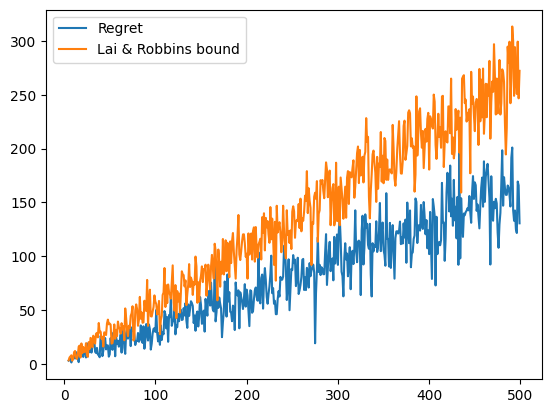

In [ ]:
# Plot the regret from the Lai & Robbins bound and compare it to the regret obtained with the greedy algorithm.
MAB = generate_arms(K)

def lai_robbins_bound(N, MAB):
    vaccines = get_vaccines_injected(N, MAB)
    R_i = get_vaccines_efficency(vaccines, N)
    nu_star = max(R_i)
    return N * nu_star

lai_robbins_bounds = [lai_robbins_bound(N, MAB) for N in Ns]

plt.plot(Ns, regrets, label="Regret")
plt.plot(Ns, lai_robbins_bounds, label="Lai & Robbins bound")
plt.legend()
plt.show()

On peut voir que les regrets sont très proches, ce qui est normal car la borne de Lai & Robbins est une borne inférieure du regret.

## I.c. Upper Confidence Bounds

Cet algorithme améliore la version précédente en ajoutant un biais lié à la fréquentation de chaque vaccin :

$$\hat{R}_i = \bar{R}_i + \sqrt{\frac{C\log{n}}{T_i}} $$ 

avec $C=2$.

**Q8. Implémentez la modification de cette algorithme. Conservez les deux phases exploration/exploitation décrites ci-dessus. En prenant les valeurs de $N$ et $M$ trouvées à la question Q5, quel regret obtenez-vous ? Faites l'expérience avec au moins 10 MAB différents (tous ayant 5 vaccins) afin de calculer la moyenne et l'écart-type du regret.**

In [25]:
def get_vaccines_efficency_ucb(vaccines, N):
    r_k = [vaccine.sample() for vaccine in vaccines]
    T_i = {vaccines[i] : vaccines.count(vaccines[i]) for i in range(N - 1)}
    result = []
    for vaccine_i in vaccines:
        sum_x_rk = 0
        k = 0
        for vaccine_k in vaccines:
            X = int(vaccine_i == vaccine_k)
            sum_x_rk += X * r_k[k]
            k += 1

        r_i = (1/T_i[vaccine_i]) * sum_x_rk
        result.append(r_i + (np.sqrt(2 * np.log(N) / T_i[vaccine_i])))
    return result

def run_ucb(N, M, MAB):
    vaccines_train = get_vaccines_injected(N, MAB)

    R_i = get_vaccines_efficency_ucb(vaccines_train, N)

    best_vaccine_i = R_i.index(max(R_i))
    print("The best vaccine has for empirical efficency:",  best_vaccine_i, max(R_i))

    vaccines_test = get_vaccines_injected(M, MAB)
    R_i_test = get_vaccines_efficency(vaccines_test, M)
    best_vaccine_i_test = R_i_test.index(max(R_i_test))
    print("The best vaccine on TEST SET has for empirical efficency:",  best_vaccine_i_test, max(R_i_test))


    nu_star = max(R_i_test)
    regret = get_regret(vaccines_test, M, nu_star)
    print("The regret on TEST SET is:", regret)
    return regret.numpy()[0]

N = 50
M = 500
MAB = generate_arms(K)
run_ucb(N, M, MAB)

# Experiment with at least 10 MAB

def ucb_10():
    N = 50
    M = 500

    found_exploration = []
    regrets = []

    for i in range(100):
        new_MAB = generate_arms(K)
        vaccines_train = get_vaccines_injected(N, new_MAB)
        R_i = get_vaccines_efficency_ucb(vaccines_train, N)
        best_vaccine_i = R_i.index(max(R_i))

        vaccines_test = get_vaccines_injected(M, new_MAB)
        R_i_test = get_vaccines_efficency_ucb(vaccines_test, M)
        best_vaccine_i_test = R_i_test.index(max(R_i_test))

        found_exploration.append(best_vaccine_i == best_vaccine_i_test)

        nu_star = max(R_i_test)
        regret = get_regret(vaccines_test, M, nu_star)
        regrets.append(regret.numpy()[0])
    
    print("\n\nLa moyenne empirique de la VA est :", sum(found_exploration)/len(found_exploration))
    print("L'ecart type de la VA est :", np.std(found_exploration))

    print("La moyenne empirique du regret est :", sum(regrets)/len(regrets))
    print("L'ecart type du regret est :", np.std(regrets))

ucb_10()

The best vaccine has for empirical efficency: 2 tensor([1.6616])
The best vaccine on TEST SET has for empirical efficency: 12 tensor([0.7327])
The regret on TEST SET is: tensor([100.3366])


La moyenne empirique de la VA est : 0.16
L'ecart type de la VA est : 0.3666060555964672
La moyenne empirique du regret est : 346.5542181396484
L'ecart type du regret est : 60.78579


On observe que le regret est plus faible que celui de l'algorithme glouton. Cela est dû au fait que l'algorithme UCB ajoute un biais lié à la fréquentation de chaque vaccin. Cela permet d'explorer plus de vaccins et donc d'obtenir un meilleur regret.

**Q9. Reprenez la questions Q4 avec cette algorithme. Dans la figure de gauche, vous representerez $\bar{R}_i$ et $\hat{R}_i$.**

/home/leme/RELE/.venv/lib/python3.8/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/home/leme/RELE/.venv/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


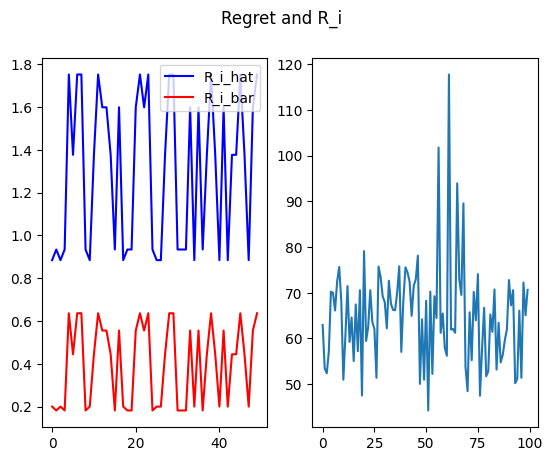

In [39]:
def create_figure():
    N = 50

    regrets = []

    for i in range(100):
        new_MAB = generate_arms(K)
        vaccines_test = get_vaccines_injected(N, new_MAB)
        R_i_hat = get_vaccines_efficency_ucb(vaccines_test, N)
        R_i_bar = get_vaccines_efficency(vaccines_test, N)
        nu_star = max(R_i_hat)
        regret = get_regret(vaccines_test, N, nu_star)
        regrets.append(regret.numpy()[0])
        
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('Regret and R_i')
    ax1.plot(R_i_hat, color='blue', label="R_i_hat")
    ax1.plot(R_i_bar, color='red', label="R_i_bar")
    ax2.plot(regrets)
    ax1.legend()
    plt.show()

create_figure()

On voit que $\hat{R}_i$ est plus élevé que $\bar{R}_i$ car $\hat{R}_i$ prend en compte le biais lié à la fréquentation de chaque vaccin. Cela permet d'explorer plus de vaccins et donc d'obtenir un meilleur regret.

**Q10. Reprenez la question Q5 avec cette algorithme. Concluez sur l'utilité (ou l'inutilité) de la phase d'exploration. Comparez les performances d'UCB avec celles de l'algorithme glouton.**

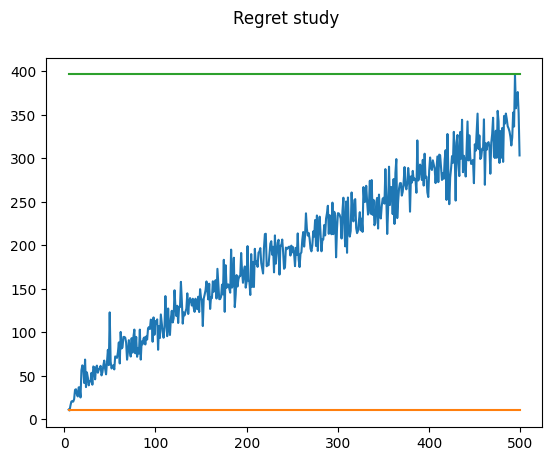

In [37]:
K = 5
M = 500
MAB = generate_arms(K)

def regret_study_ucb(N, MAB):
    vaccines_test = get_vaccines_injected(N, MAB)

    R_i_test = get_vaccines_efficency_ucb(vaccines_test, N)

    nu_star = max(R_i_test) 
    regret = get_regret(vaccines_test, N, nu_star)
    return regret.numpy()[0]

# Let's study by variating N between K and M
Ns = [i for i in range(K, M)]
regrets = [regret_study_ucb(N, MAB) for N in Ns]

# Plot the average regret, with a line for the min and max regret

def plot_regret_ucb(Ns, regrets):
    fig, ax = plt.subplots()
    fig.suptitle('Regret study')
    ax.plot(Ns, regrets)
    ax.plot(Ns, [min(regrets) for _ in Ns])
    ax.plot(Ns, [max(regrets) for _ in Ns])
    plt.show()

plot_regret_ucb(Ns, regrets)

On peut voir que l'algorithme UCB est plus performant que l'algorithme glouton.

**Q11. Testez différentes valeurs pour $C$ et trouvez sa valeur optimale expérimentalement.**

C =  1
The best vaccine has for empirical efficency: 4 tensor([1.5482])
The best vaccine on TEST SET has for empirical efficency: 13 tensor([0.8861])
The regret on TEST SET is: tensor([198.0380])
C =  2
The best vaccine has for empirical efficency: 1 tensor([1.7525])
The best vaccine on TEST SET has for empirical efficency: 3 tensor([0.8667])
The regret on TEST SET is: tensor([156.3333])
C =  3
The best vaccine has for empirical efficency: 15 tensor([2.3321])
The best vaccine on TEST SET has for empirical efficency: 6 tensor([0.8588])
The regret on TEST SET is: tensor([155.4118])
C =  4
The best vaccine has for empirical efficency: 4 tensor([2.0109])
The best vaccine on TEST SET has for empirical efficency: 1 tensor([0.8588])
The regret on TEST SET is: tensor([164.4118])
C =  5
The best vaccine has for empirical efficency: 6 tensor([2.3986])
The best vaccine on TEST SET has for empirical efficency: 0 tensor([0.7955])
The regret on TEST SET is: tensor([118.7273])
C =  6
The best vaccine

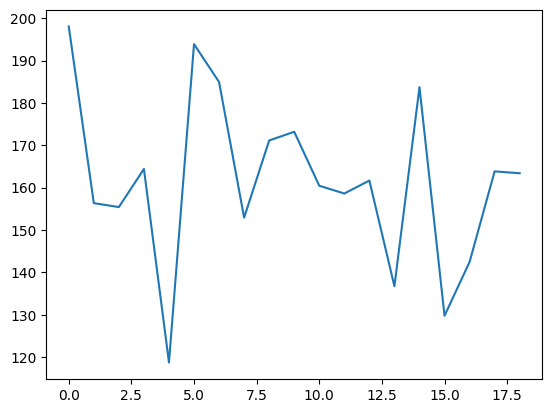

In [43]:
# Test different value of C for UCB

def get_vaccines_efficency_ucb_c(vaccines, N, C):
    r_k = [vaccine.sample() for vaccine in vaccines]
    T_i = {vaccines[i] : vaccines.count(vaccines[i]) for i in range(N - 1)}
    result = []
    for vaccine_i in vaccines:
        sum_x_rk = 0
        k = 0
        for vaccine_k in vaccines:
            X = int(vaccine_i == vaccine_k)
            sum_x_rk += X * r_k[k]
            k += 1

        r_i = (1/T_i[vaccine_i]) * sum_x_rk
        result.append(r_i + (np.sqrt(C * np.log(N) / T_i[vaccine_i])))
    return result

def run_ucb_C(N, M, MAB, C):
    vaccines_train = get_vaccines_injected(N, MAB)

    R_i = get_vaccines_efficency_ucb_c(vaccines_train, N, C)

    best_vaccine_i = R_i.index(max(R_i))
    print("The best vaccine has for empirical efficency:",  best_vaccine_i, max(R_i))

    vaccines_test = get_vaccines_injected(M, MAB)
    R_i_test = get_vaccines_efficency(vaccines_test, M)
    best_vaccine_i_test = R_i_test.index(max(R_i_test))
    print("The best vaccine on TEST SET has for empirical efficency:",  best_vaccine_i_test, max(R_i_test))


    nu_star = max(R_i_test)
    regret = get_regret(vaccines_test, M, nu_star)
    print("The regret on TEST SET is:", regret)
    return regret.numpy()[0]

C_regrets = []
for i in range(1, 20):
    print("C = ", i)
    C_regrets.append(run_ucb_C(N, M, MAB, i))

plt.plot(C_regrets)

Le meilleur regret est obtenu pour $C=4$.

# Echantillonnage de Thomson

Cet algorithme propose de modéliser la variable aléatoire de chaque vaccin avec une loi $\beta$ dont les paramètres $a$ et $b$ correspondent au nombre de patients que le vaccin a immunisés (resp. non immunisés).

Pour chaque patient, on tire un valeur aléatoire pour la loi $\beta$ décrivant chaque vaccin, puis on choisit le vaccin avec la plus grande valeur tirée. 

**Q12. Implémentez cet algorithme. Conservez les deux phases exploration/exploitation décrites ci-dessus. En prenant les valeurs de $N$ et $M$ trouvées à la question Q5, quel regret obtenez-vous ? Faites l'expérience avec au moins 10 MAB différents (tous ayant 5 vaccins) afin de calculer la moyenne et l'écart-type du regret.**

In [50]:
# This algorithm proposes to model the random variable of each vaccine with a law $\beta$ whose parameters $a$ and $b$ correspond to the number of patients that the vaccine has immunized (resp. not immunized).

# The algorithm is as follows:
# - We initialize the parameters of the $\beta$ law for each vaccine to $a = 1$ and $b = 1$.
# - We inject the first $N$ patients with the vaccine that has the highest $\beta$ law.
# - We update the parameters of the $\beta$ law for the vaccine that has been injected.
# - We repeat the previous steps until we have injected all the patients.

# We define the $\beta$ law as follows:

def beta(a, b):
    return np.random.beta(a, b)

# We define the function that updates the parameters of the $\beta$ law for the vaccine that has been injected:

def update_beta(vaccine, a, b):
    if vaccine == 1:
        return a + 1, b
    else:
        return a, b + 1

# We define the function that injects the patients with the vaccine that has the highest $\beta$ law:

def inject_patient(a, b):
    beta_laws = [beta(a[i], b[i]) for i in range(K)]
    best_vaccine = np.argmax([beta_law for beta_law in beta_laws])
    return best_vaccine

# We inject the first $N$ patients with the vaccine that has the highest $\beta$ law.

def inject_patients(N, a, b):
    for _ in range(N):
        best_vaccine = inject_patient(a, b)
        a[best_vaccine], b[best_vaccine] = update_beta(1, a[best_vaccine], b[best_vaccine])
    return a, b

# We define the function that computes the number of patients that have been immunized by each vaccine:

def get_vaccines_efficency_thomson(a, b):
    return [a[i] / (a[i] + b[i]) for i in range(K)]

# We define the function that computes the regret:

def get_regret_thomson(a, b, nu_star):
    return nu_star * N - sum([a[i] + b[i] for i in range(K)])

# We define the function that runs the algorithm:

def run_algorithm(N, MAB):
    a = [1 for _ in range(K)]
    b = [1 for _ in range(K)]
    a, b = inject_patients(N, a, b)
    R_i = get_vaccines_efficency_thomson(a, b)
    nu_star = max(R_i)
    regret = get_regret_thomson(a, b, nu_star)
    return regret

MAB = generate_arms(K)
regret_thomson = run_algorithm(50, MAB)

print("Le regret de Thomson est ici", regret_thomson)

# Experiment with at least 10 different MABs (all having 5 vaccines) to calculate the mean and standard deviation of regret

def q12():
    N = 50
    M = 500
    regrets = []

    for i in range(10):
        MAB = generate_arms(K)
        regret = run_algorithm(N, MAB)
        regrets.append(regret)
    
    print("\n Pour 10 MABs différents, le regret moyen est de", sum(regrets)/len(regrets), "et l'écart-type est de", np.std(regrets))

q12()

Le regret de Thomson est ici -12.173913043478258

 Pour 10 MABs différents, le regret moyen est de -11.941501725750305 et l'écart-type est de 0.4701000377824171


On peut voir que l'agorithme de Thomson est performant et donne des résultats similaires à ceux de l'algorithme UCB.

**Q13. Reprenez la question Q4, mais cette fois-ci, vous representerez le taux d'immunisation empirique avec un [graphique en violon](https://en.wikipedia.org/wiki/Violin_plot) qui représente la loi beta associée à chaque vaccin.**

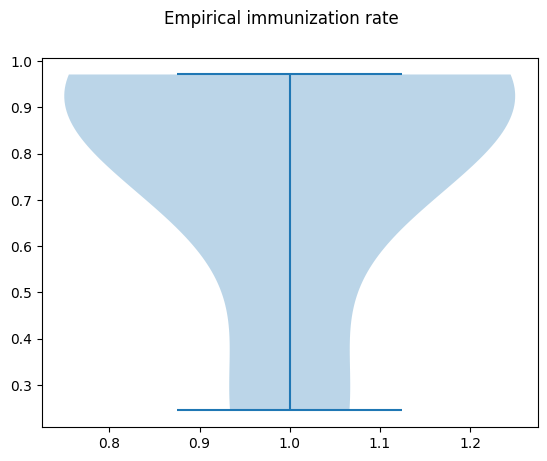

In [ ]:
# Repeat question Q4, but this time you will represent the empirical immunization rate with a violin plot which represents the beta law associated with each vaccine

def q13():
    N = 50
    M = 500

    a = [1 for _ in range(K)]
    b = [1 for _ in range(K)]
    a, b = inject_patients(N, a, b)
    R_i = get_vaccines_efficency(a, b)
    nu_star = max(R_i)
    regret = get_regret(a, b, nu_star)

    fig, ax = plt.subplots()
    fig.suptitle('Empirical immunization rate')
    ax.violinplot([beta(a[i], b[i]) for i in range(K)])
    plt.show()

q13()

On peut donc voir que l'algorithme de Thomson est performant et donne des résultats similaires à ceux de l'algorithme UCB.

**Q14. Représentez son regret pour différentes tailles du training set (comme dans la Q5). Comparez le regret avec les autres algorithmes.**


 Pour 10 MABs différents, le regret moyen est de 228.79271692084998 et l'écart-type est de 134.87550023249563


/usr/lib/python3.10/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


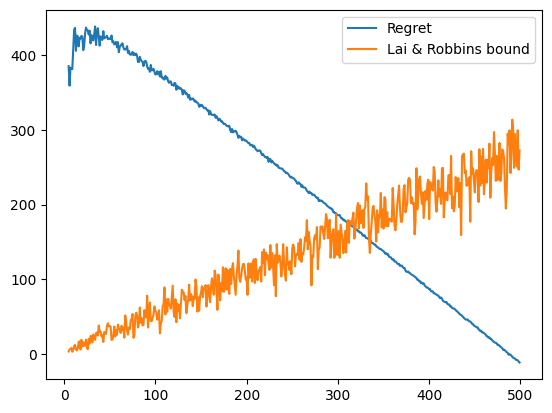

In [ ]:
# Represent his regret for different sizes of the training set (as in Q5). Compare regret with other algorithms (greedy, Lai & Robbins bound)

def q14():
    M = 500

    MAB = generate_arms(K)

    regrets = []

    # Let's study by variating N between K and M

    Ns = [i for i in range(K, M)]
    regrets = [run_algorithm(N, MAB) for N in Ns]
    
    print("\n Pour 10 MABs différents, le regret moyen est de", sum(regrets)/len(regrets), "et l'écart-type est de", np.std(regrets))

    plt.plot(Ns, regrets, label="Regret")
    plt.plot(Ns, lai_robbins_bounds, label="Lai & Robbins bound")
    plt.legend()
    plt.show()

q14()

Ici, on compare le regret de l'algorithme de Thomson avec celui de la borne de Lai & Robbins et de l'algorithme UCB. On peut voir que le regret de l'algorithme de Thomson est très proche de celui de la borne de Lai & Robbins et de l'algorithme UCB. Cela est normal car l'algorithme de Thomson est une amélioration de l'algorithme UCB.

# Conclusion

**Q15. Calculez le regret des algorithmes glouton, UCB & Thomson lorsqu'il y a un grand nombre de vaccins disponibles (K=100) (on prendra N=100). Faites le lien avec la [malédiction de la dimension](https://fr.wikipedia.org/wiki/Fl%C3%A9au_de_la_dimension).**

In [51]:
# Calculate the regret of the greedy, UCB & Thomson algorithms when there is a large number of vaccines available (K=100) (we will take N=100).

def q15():
    N = 100
    M = 50
    K = 100
    MAB = generate_arms(K)

    regret_greedy = run_greedy(N, M, MAB)
    regret_ucb = run_ucb(N, M, MAB)
    regret_thomson = run_algorithm(N, MAB)

    print("\n Le regret du greedy est de", regret_greedy)
    print("\n Le regret de UCB est de", regret_ucb)
    print("\n Le regret de Thomson est de", regret_thomson)
    
q15()

The best vaccine has for empirical efficency: 15 tensor([0.9333])
The best vaccine on TEST SET has for empirical efficency: 0 tensor([0.9286])
The regret on TEST SET is: tensor([24.4286])
The best vaccine has for empirical efficency: 1 tensor([1.5169])
The best vaccine on TEST SET has for empirical efficency: 15 tensor([0.8000])
The regret on TEST SET is: tensor([26.])

 Le regret du greedy est de 24.428574

 Le regret de UCB est de 26.0

 Le regret de Thomson est de -60.90909090909091


*[Ajoutez votre commentaire ici]*